### 21.3.1 환경 준비 - Anaconda에서 개발환경 만들기
```bash
conda env create -f env_CH21.yml
conda activate book-word2vec
git clone https://github.com/machrisaa/tensorflow-vgg tensorflow_vgg
```

In [1]:
import time
import numpy as np
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

In [2]:
dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [01:34, 331kB/s]


In [3]:
from collections import Counter
def preprocess(text):	
    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurrences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [4]:
words =preprocess(text)
print(words[:30])
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']
Total words: 16680599
Unique words: 63641


In [5]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [6]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [7]:
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [8]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [12]:
with train_graph.as_default():
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

In [14]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

t, sisyphus, equation, dy, sopwith,
Nearest to troops: battle, naval, brigade, defeat, frans, canmore, prelate, assistance,
Nearest to professional: universities, wrestling, wrestler, laetrile, basketball, lubwa, amish, distinct,
Nearest to gold: silver, coins, precious, decorations, color, colored, platinum, cristobal,
Nearest to joseph: christ, mormon, macroeconomics, caron, valerie, aznavour, devoted, step,
Epoch 8/10 Iteration: 36100 Avg. Training loss: 3.9623 0.0214 sec/batch
Epoch 8/10 Iteration: 36200 Avg. Training loss: 3.9207 0.0208 sec/batch
Epoch 8/10 Iteration: 36300 Avg. Training loss: 3.8896 0.0208 sec/batch
Epoch 8/10 Iteration: 36400 Avg. Training loss: 3.8194 0.0208 sec/batch
Epoch 8/10 Iteration: 36500 Avg. Training loss: 3.8451 0.0207 sec/batch
Epoch 8/10 Iteration: 36600 Avg. Training loss: 3.7669 0.0207 sec/batch
Epoch 8/10 Iteration: 36700 Avg. Training loss: 3.8879 0.0215 sec/batch
Epoch 8/10 Iteration: 36800 Avg. Training loss: 3.8856 0.0209 sec/batch
Epoch 8/10

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

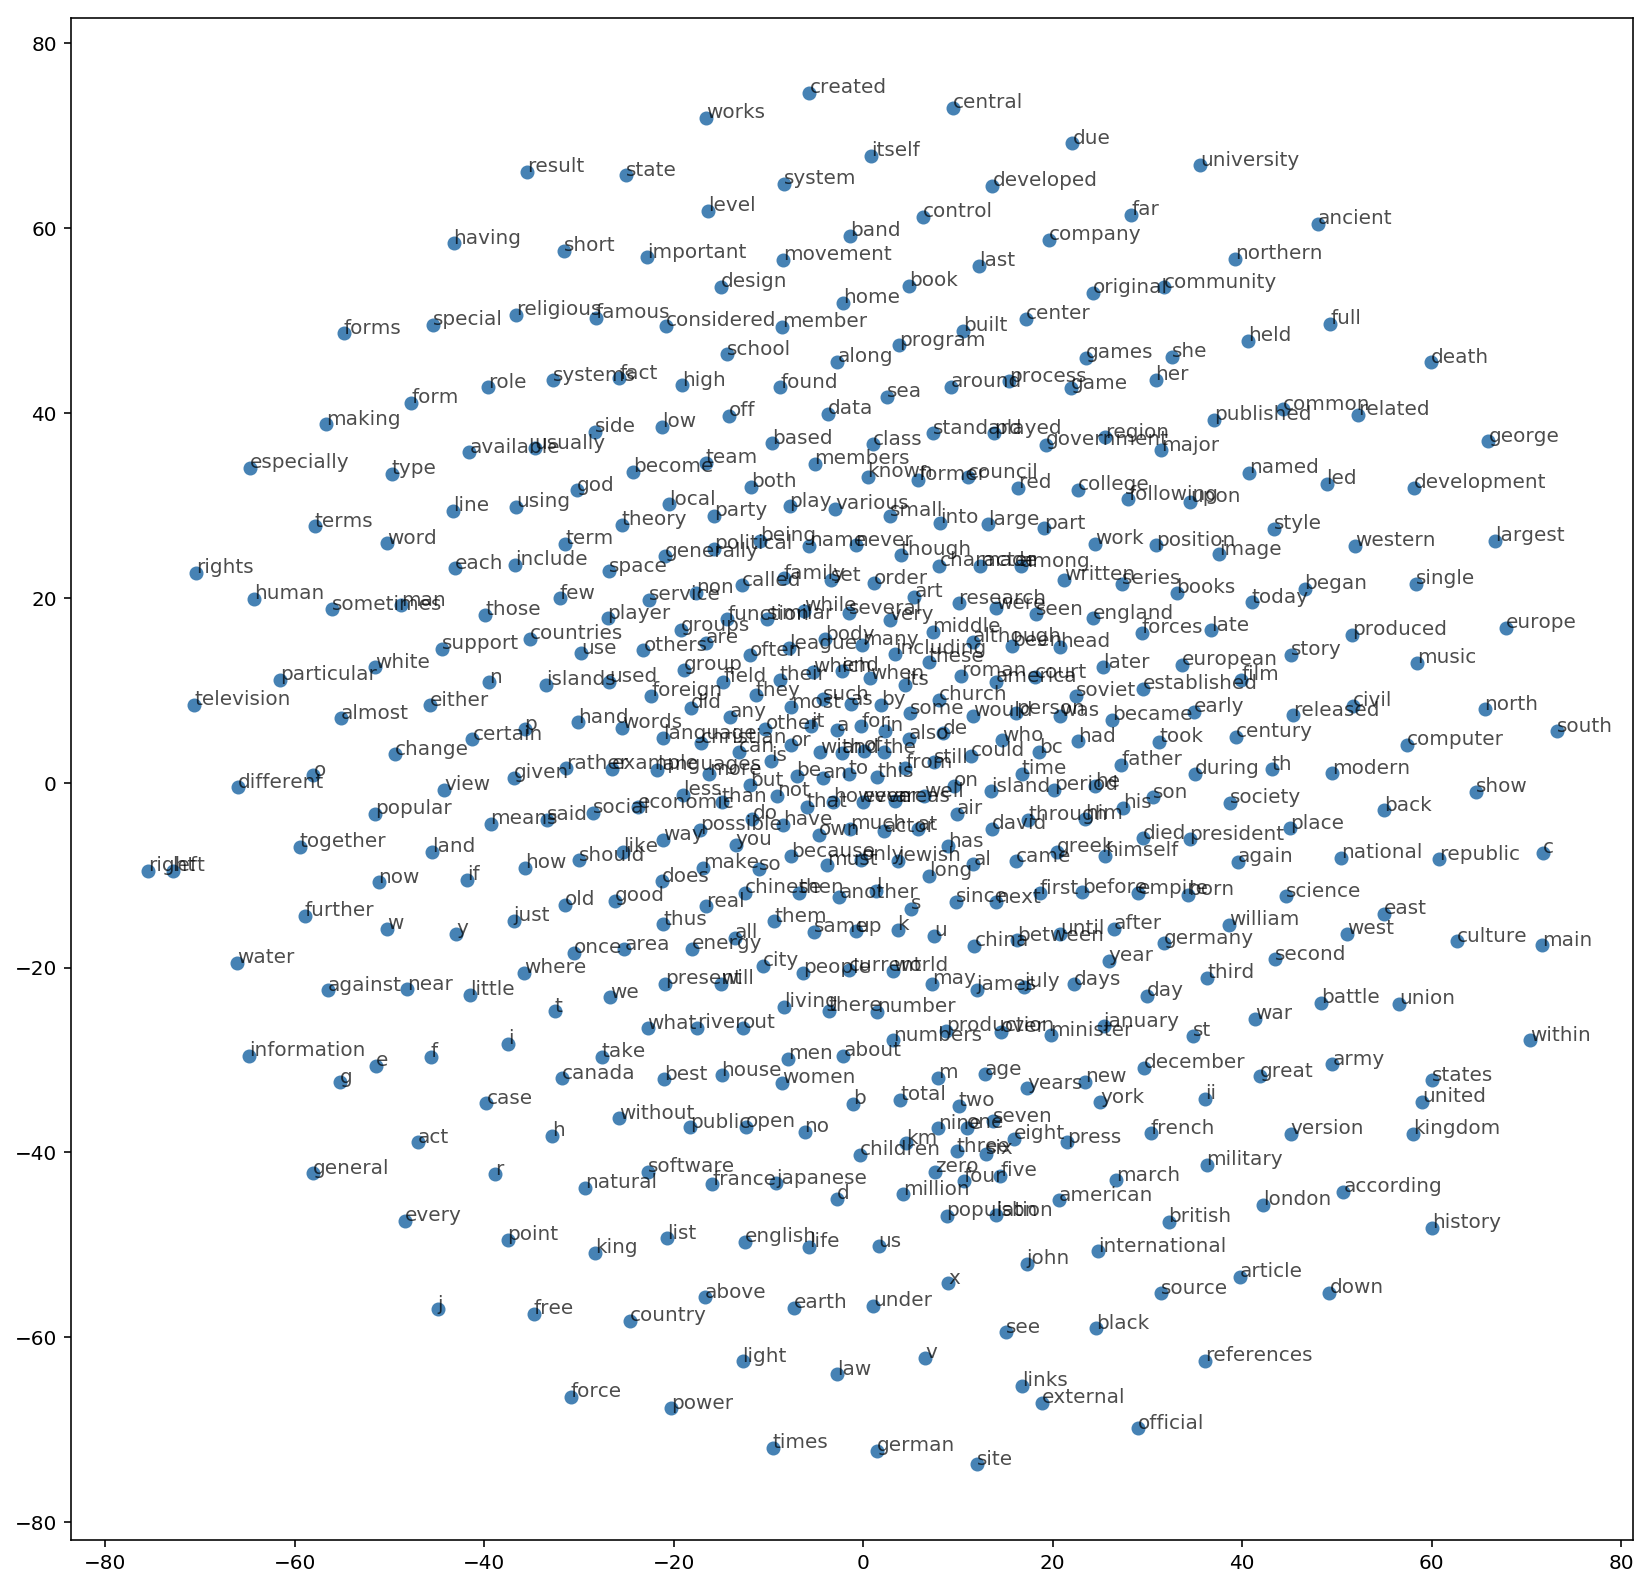

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)